# Segmenting and Clustering Neighborhoods in Monterrey, MX

## Introduction

An entrepreneur is interested in opening a small Taco Place in the City of Monterrey, Mexico, and she needs to identify a Neighborhood with not too much competitors but with enough customers for what she is planning to offer. In this project, we get addresses with latitude and longitude values for the City of Monterrey, to be able to locate th best place to open that small Restaurant. 

We use the **explore** function from the Foursquare API to explore neighborhoods and get the most common venue categories in each neighborhood, and then use this feature to group the neighborhoods into clusters. 

We also use the *k*-means clustering algorithm to complete this task. 

Finally, we use the Folium library to visualize the neighborhoods in Monterrey and their identified clusters.

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>
  <ol>
    <li> <a href="#item1">Download and Explore Dataset</a></li>
    <li><a href="#item2">Explore Neighborhoods in Monterrey</a></li>
    <li><a href="#item3">Analyze Each Neighborhood</a></li>
    <li><a href="#item4">Cluster Neighborhoods</a></li>
    <li><a href="#item5">Examine Clusters</a></li>
  </ol>
</font>
</div>

First, we download and import all the dependencies we will need for the project.

In [1]:
import types
import pandas as pd
import numpy as np
import requests # library to handle requests
import json # library to handle JSON files
from botocore.client import Config
import ibm_boto3

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

!conda install -c conda-forge folium=0.5.0 --yes #To install folium
import folium # map rendering library

print('Libraries imported.')


Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/DSX-Python35

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.6.16  |       hecc5488_0         145 KB  conda-forge
    openssl-1.0.2r             |       h14c3975_0         3.1 MB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    certifi-2018.8.24          |        py35_1001         139 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    altair-2.2.2               |           py35_1         462 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         4.0 MB

The following NEW packages will

## 1. Download and Explore Dataset

The file with Postal Codes and Coordinates for Mexico's country, was obtained from this url: http://download.geonames.org/export/zip/

The file was in zip format. After decompressing the file, the records for the city of Monterrey were put in a CSV file.


In [2]:
# The code was removed by Watson Studio for sharing.

The CSV File was uploaded to the Project, and now it's loaded into a Dataframe.
And we need a copy with the Coordinates to use after grouping the Postal Codes.

In [3]:
table_df = pd.read_csv(body, encoding = 'unicode_escape')

latlon_df = table_df.copy()

table_df.head()

,PostalCode,Neighborhood,State,County,Latitude,Longitude
0,66600,Santa Rosa II,Nuevo Leon,Apodaca,25.7862,-100.1859
1,66600,Futuro Apodaca,Nuevo Leon,Apodaca,25.7814,-100.1800
2,66600,Manuel Villarreal,Nuevo Leon,Apodaca,25.7853,-100.1816
3,66600,Homero Sepulveda,Nuevo Leon,Apodaca,25.7765,-100.1910
4,66600,Moderno Apodaca II,Nuevo Leon,Apodaca,25.7823,-100.1846


In [4]:
table_df.shape

(3782, 6)

In this step, we group the Postal Codes that are repeated

In [5]:
table_df = table_df.groupby('PostalCode', as_index=False).agg(lambda x: ', '.join(set(x.dropna())))

table_df.head(10)

,PostalCode,Neighborhood,State,County
0,64000,"La Finca, Monterrey Centro",Nuevo Leon,Monterrey
1,64004,Amway,Nuevo Leon,Monterrey
2,64006,Consulado General de los Estados Unidos de Nor...,Nuevo Leon,Monterrey
3,64007,Secretaria de Hacienda y CrEdito Publico,Nuevo Leon,Monterrey
4,64009,Palacio de Gobierno Del Estado de Nuevo Leon,Nuevo Leon,Monterrey
5,64010,Obrera,Nuevo Leon,Monterrey
6,64018,"Desarrollo Urbano Reforma, Nuevo Centro Monterrey",Nuevo Leon,Monterrey
7,64019,Condominios Constitucion,Nuevo Leon,Monterrey
8,64020,"Gonzalitos, Mitras Sur",Nuevo Leon,Monterrey
9,64030,"Lomas, Chepevera",Nuevo Leon,Monterrey


In [6]:
table_df.shape

(659, 4)

And since the Coordinates were removed in the previous step, we get them from the Copy made in previous step.

In [7]:
latlon_df.head()

,PostalCode,Neighborhood,State,County,Latitude,Longitude
0,66600,Santa Rosa II,Nuevo Leon,Apodaca,25.7862,-100.1859
1,66600,Futuro Apodaca,Nuevo Leon,Apodaca,25.7814,-100.1800
2,66600,Manuel Villarreal,Nuevo Leon,Apodaca,25.7853,-100.1816
3,66600,Homero Sepulveda,Nuevo Leon,Apodaca,25.7765,-100.1910
4,66600,Moderno Apodaca II,Nuevo Leon,Apodaca,25.7823,-100.1846


And merge them in a new Dataframe.

In [8]:
mty_df = pd.merge(left=table_df, right=latlon_df)
mty_df.head(12)

,PostalCode,Neighborhood,State,County,Latitude,Longitude
0,64004,Amway,Nuevo Leon,Monterrey,25.7334,-100.3321
1,64006,Consulado General de los Estados Unidos de Nor...,Nuevo Leon,Monterrey,25.7334,-100.3321
2,64007,Secretaria de Hacienda y CrEdito Publico,Nuevo Leon,Monterrey,25.7334,-100.3321
3,64009,Palacio de Gobierno Del Estado de Nuevo Leon,Nuevo Leon,Monterrey,25.7334,-100.3321
4,64010,Obrera,Nuevo Leon,Monterrey,25.7334,-100.3321
5,64019,Condominios Constitucion,Nuevo Leon,Monterrey,25.7334,-100.3321
6,64049,Exseminario,Nuevo Leon,Monterrey,25.7334,-100.3321
7,64060,Obispado,Nuevo Leon,Monterrey,25.6449,-100.3110
8,64070,El Mirador Centro,Nuevo Leon,Monterrey,25.7334,-100.3321
9,64107,Colina de San BernabE F-25,Nuevo Leon,Monterrey,25.7867,-100.3714


In [10]:
mty_df.shape

(193, 6)

We need to get Coordinates for Monterrey

In [11]:
address = 'Monterrey, Nuevo Leon'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinates of Monterrey are {}, {}.'.format(latitude, longitude))

The geographical coordinates of Monterrey are 25.63978365, -100.293101629066.


And map them, using Folium

In [12]:
mty_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map with popups
for lat, long, label in zip(mty_df['Latitude'], mty_df['Longitude'], mty_df['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, long],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(mty_map)  
    
mty_map

Here, we prepare to Connect to Foursquare API

In [15]:
CLIENT_ID = 'GO42HGIG1TV3WMP3KWPMYMCWLH5QM1XJRWWNHA0WHIAHBS1U' # your Foursquare ID
CLIENT_SECRET = '5OJIXMNGAXNZEKNOY2W1JDXUUY50AI1P23ZJRBR4N4QYAU00' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: GO42HGIG1TV3WMP3KWPMYMCWLH5QM1XJRWWNHA0WHIAHBS1U
CLIENT_SECRET:5OJIXMNGAXNZEKNOY2W1JDXUUY50AI1P23ZJRBR4N4QYAU00


And we explore the first County

In [16]:
print('First County: ', mty_df.loc[0, 'County'])

neighborhood_lati = mty_df.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_long = mty_df.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = mty_df.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_lati, 
                                                               neighborhood_long))

First County:  Monterrey
Latitude and longitude values of Amway are 25.7334, -100.3321.


And now, we get the top 100 Venues for this Neighborhood, with a Radius of 500 meters

In [17]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 800 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_lati, 
    neighborhood_long, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=GO42HGIG1TV3WMP3KWPMYMCWLH5QM1XJRWWNHA0WHIAHBS1U&client_secret=5OJIXMNGAXNZEKNOY2W1JDXUUY50AI1P23ZJRBR4N4QYAU00&v=20180605&ll=25.7334,-100.3321&radius=800&limit=100'

In this step, we send the GET request and review the results

In [18]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5d1929a1348eba0023789e74'},
 'response': {'groups': [{'items': [{'reasons': {'count': 0,
       'items': [{'reasonName': 'globalInteractionReason',
         'summary': 'This spot is popular',
         'type': 'general'}]},
      'referralId': 'e-0-509a78d4498ebbcaf4501bdb-0',
      'venue': {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/juicebar_',
          'suffix': '.png'},
         'id': '4bf58dd8d48988d112941735',
         'name': 'Juice Bar',
         'pluralName': 'Juice Bars',
         'primary': True,
         'shortName': 'Juice Bar'}],
       'id': '509a78d4498ebbcaf4501bdb',
       'location': {'cc': 'MX',
        'city': 'Monterrey',
        'country': 'México',
        'distance': 240,
        'formattedAddress': ['Monterrey, Nuevo León', 'México'],
        'labeledLatLngs': [{'label': 'display',
          'lat': 25.7346,
          'lng': -100.3341}],
        'lat': 25.7346,
        'lng': -100.3341,
 

Now, we need a function to clean up the results in json and put it into a Dataframe

In [19]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [20]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Jugos la Adelita,Juice Bar,25.734600,-100.334100
1,Motel Casa Blanca,Motel,25.734343,-100.333900
2,josephinos anahuac,Afghan Restaurant,25.736431,-100.330414
3,Cinépolis VIP,Movie Theater,25.737155,-100.331713


In [21]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

4 venues were returned by Foursquare.


## 2. Explore Neighborhoods in Monterrey

#### Let's create a function to repeat the same process to all the neighborhoods in Monterrey

In [22]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

mty_venues = getNearbyVenues(names=mty_df['Neighborhood'],
                                   latitudes=mty_df['Latitude'],
                                   longitudes=mty_df['Longitude']
                                  )


Amway
Consulado General de los Estados Unidos de NorteAmerica
Secretaria de Hacienda y CrEdito Publico
Palacio de Gobierno Del Estado de Nuevo Leon
Obrera
Condominios Constitucion
Exseminario
Obispado
El Mirador Centro
Colina de San BernabE F-25
Plutarco Elias Calles
Paseo de las Mitras
Fidel Velazquez S. N. A. T.
Loma Linda
Villa Alegre
Paso del aguila
Genaro Rojas Vazquez
Lomas de Santa Cecilia
Aztlan
Lomas de La Unidad Modelo
Abelardo Zapata
Bortoni
5 de Mayo
Central
CROC
Valle de San Martin F-24
Lomas de Topo Chico
Conquistadores
Tierra Propia F-35
5 de Mayo F-93
La Amistad
Villa San angel Topo Chico
Francisco Villa
San angel F-78
Fray Servando Teresa de Mier F-6
18 de Febrero
Tierra y Libertad Sector Heroico
Predio Zapata
Tierra y Libertad Sector Sur
Cnop
Tierra y Libertad Sector Centro
Plan de San Luis
Madero
Carmen Serdan
Valle del Topo Chico
La Meseta
Lazaro Cardenas
Mitras Norte
Cumbre Allegro
Patronato Cruz Verde
Rincon de las Cumbres
Valle de los Cedros
Estrella
Heriberto Ja

Now, let's see the resulting Dataframe

In [23]:
print(mty_venues.shape)
mty_venues.head()

(1335, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Amway,25.7334,-100.3321,Jugos la Adelita,25.734600,-100.334100,Juice Bar
1,Amway,25.7334,-100.3321,Motel Casa Blanca,25.734343,-100.333900,Motel
2,Amway,25.7334,-100.3321,"Corporacion RNB, S.A. de C.V.",25.734764,-100.334111,Candy Store
3,Amway,25.7334,-100.3321,josephinos anahuac,25.736431,-100.330414,Afghan Restaurant
4,Amway,25.7334,-100.3321,Cinépolis VIP,25.737155,-100.331713,Movie Theater


Let's check how many venues were returned for each Neighborhood

In [26]:
mty_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
10 de Marzo,11,11,11,11,11,11
15 de Mayo Larralde,11,11,11,11,11,11
18 de Febrero,1,1,1,1,1,1
25 de Marzo Sierra Ventana,11,11,11,11,11,11
27 de Mayo,4,4,4,4,4,4
5 de Mayo,8,8,8,8,8,8
5 de Mayo F-93,1,1,1,1,1,1
Abelardo Zapata,4,4,4,4,4,4
Almaguer,2,2,2,2,2,2


In [43]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [44]:
mty_venues_grouped = mty_venues.groupby('Neighborhood').count()

mty_venues_grouped.head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
10 de Marzo,11,11,11,11,11,11
15 de Mayo Larralde,11,11,11,11,11,11
18 de Febrero,1,1,1,1,1,1
25 de Marzo Sierra Ventana,11,11,11,11,11,11
27 de Mayo,4,4,4,4,4,4


In [45]:
mty_venues_grouped.drop(["Neighborhood Latitude", "Neighborhood Longitude", "Venue Latitude", "Venue Longitude", "Venue Category"], axis=1, inplace=True)

mty_venues_grouped = mty_venues_grouped.sort_values(by=['Venue'])

mty_venues_grouped.head()

,Venue
Neighborhood,
Zona Industrial,1
Grutas de Villa de Garcia,1
Idelfonso Vazquez,1
Jardines de Santiago,1
Las Brisas Residencial,1


Current size: [18.0, 8.0]


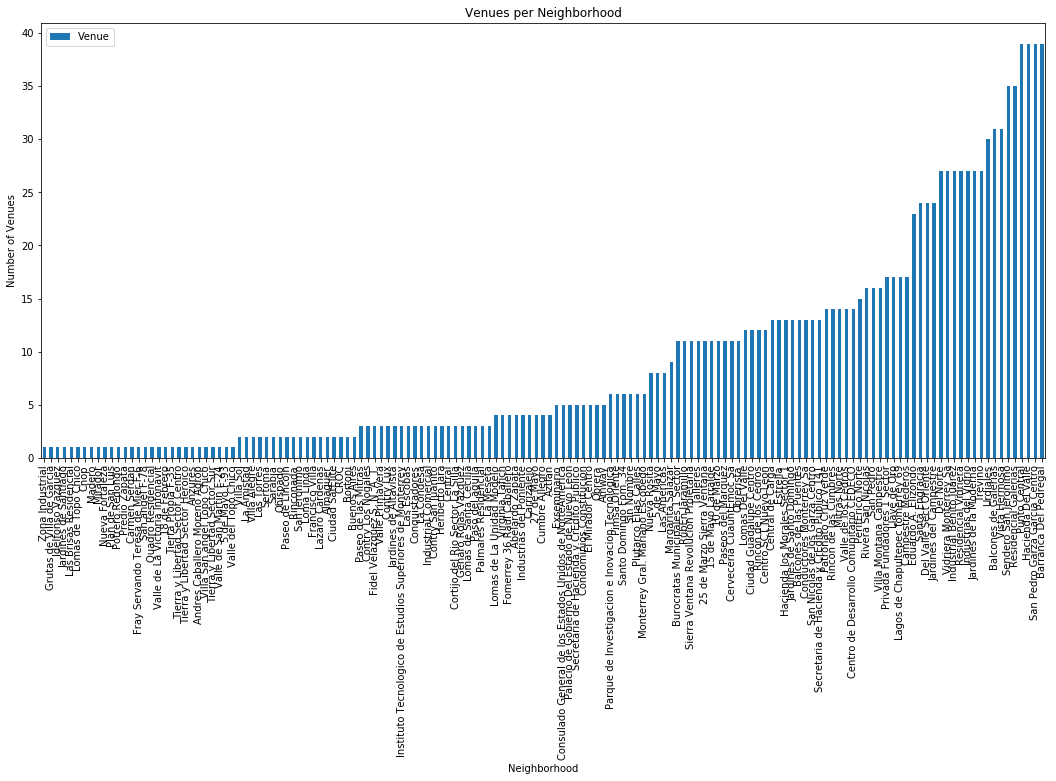

In [53]:
fig_size = plt.rcParams["figure.figsize"]

# Prints: [8.0, 6.0]
print ("Current size:", fig_size)

# Set figure width to 18 and height to 8
fig_size[0] = 18
fig_size[1] = 8

plt.rcParams["figure.figsize"] = fig_size


mty_venues_grouped.plot(kind="bar")

plt.title("Venues per Neighborhood")
plt.ylabel("Number of Venues")
plt.xlabel("Neighborhood")


plt.show()


Let's find out how many unique categories can be curated from all the returned venues

In [54]:
print('There are {} uniques categories.'.format(len(mty_venues['Venue Category'].unique())))

There are 128 uniques categories.


## 3. Analyze Each Neighborhood

In [55]:
# one hot encoding
mty_onehot = pd.get_dummies(mty_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
mty_onehot['Neighborhood'] = mty_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [mty_onehot.columns[-1]] + list(mty_onehot.columns[:-1])
mty_onehot = mty_onehot[fixed_columns]

mty_onehot.head()

,Yoga Studio,Accessories Store,Afghan Restaurant,American Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,...,Sushi Restaurant,Swim School,Taco Place,Tea Room,Tennis Court,Town,Track Stadium,Video Store,Warehouse Store,Wings Joint
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's examine the new dataframe size

In [56]:
mty_onehot.shape

(1335, 128)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [57]:
mty_grouped = mty_onehot.groupby('Neighborhood').mean().reset_index()
mty_grouped

,Neighborhood,Yoga Studio,Accessories Store,Afghan Restaurant,American Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Sushi Restaurant,Swim School,Taco Place,Tea Room,Tennis Court,Town,Track Stadium,Video Store,Warehouse Store,Wings Joint
0,10 de Marzo,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.090909,0.000000,0.0000,0.0,0.000000,0.000000,0.0,0.000000
1,15 de Mayo Larralde,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.090909,0.000000,0.0000,0.0,0.000000,0.000000,0.0,0.000000
2,18 de Febrero,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.000000,0.000000,0.0,0.000000
3,25 de Marzo Sierra Ventana,0.000000,0.000000,0.0,0.000000,0.000000,0.090909,0.0,0.000000,0.000000,...,0.000000,0.000000,0.272727,0.000000,0.0000,0.0,0.000000,0.000000,0.0,0.000000
4,27 de Mayo,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.250000,0.000000,0.0000,0.0,0.000000,0.000000,0.0,0.000000
5,5 de Mayo,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.125000,0.000000,0.0000,0.0,0.000000,0.000000,0.0,0.000000
6,5 de Mayo F-93,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.0000,0.0,0.000000,0.000000,0.0,0.000000
7,Abelardo Zapata,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.000000,0.000000,0.0,0.000000
8,Almaguer,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.5,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.000000,0.000000,0.0,0.000000
9,Amway,0.000000,0.000000,0.2,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.000000,0.000000,0.0,0.000000


Let's confirm the new size

In [58]:
mty_grouped.shape

(149, 128)

Let's print each neighborhood along with the top 5 most common venues

In [33]:
num_top_venues = 5

for hood in mty_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = mty_grouped[mty_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----10 de Marzo----
                  venue  freq
0    Seafood Restaurant  0.27
1    Mexican Restaurant  0.18
2              Pharmacy  0.09
3                   Gym  0.09
4  Fast Food Restaurant  0.09


----15 de Mayo Larralde----
                  venue  freq
0    Seafood Restaurant  0.27
1    Mexican Restaurant  0.18
2              Pharmacy  0.09
3                   Gym  0.09
4  Fast Food Restaurant  0.09


----18 de Febrero----
                           venue  freq
0                       Pharmacy   1.0
1                    Yoga Studio   0.0
2                   Liquor Store   0.0
3                           Park   0.0
4  Paper / Office Supplies Store   0.0


----25 de Marzo Sierra Ventana----
           venue  freq
0     Taco Place  0.27
1      Pool Hall  0.18
2            Bar  0.18
3  Grocery Store  0.09
4    Art Gallery  0.09


----27 de Mayo----
               venue  freq
0           Pharmacy  0.25
1  Convenience Store  0.25
2      Shopping Mall  0.25
3         Taco Place  0.25
4

Now, we need to put these results into a Pandas Dataframe

But first, we need a function to sort the Venues in descending order

In [59]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now, let's create the new dataframe and display the top 10 venues for each neighborhood

In [69]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = mty_grouped['Neighborhood']

for ind in np.arange(mty_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(mty_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,10 de Marzo,Seafood Restaurant,Mexican Restaurant,Juice Bar,Gym,Pharmacy,Convenience Store,Taco Place,Fast Food Restaurant,Cycle Studio,Comfort Food Restaurant
1,15 de Mayo Larralde,Seafood Restaurant,Mexican Restaurant,Juice Bar,Gym,Pharmacy,Convenience Store,Taco Place,Fast Food Restaurant,Cycle Studio,Comfort Food Restaurant
2,18 de Febrero,Pharmacy,Candy Store,Casino,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant
3,25 de Marzo Sierra Ventana,Taco Place,Bar,Pool Hall,Grocery Store,Art Gallery,Mobile Phone Shop,Mexican Restaurant,Coffee Shop,Cocktail Bar,Dessert Shop
4,27 de Mayo,Shopping Mall,Pharmacy,Convenience Store,Taco Place,Comedy Club,Department Store,Deli / Bodega,Cycle Studio,Comfort Food Restaurant,Wings Joint


## 4. Cluster Neighborhoods

#### Let's find the optimal K by using the Elbow method

In [70]:
from sklearn import metrics
from scipy.spatial.distance import cdist

In [71]:
mty_grouped_clustering = mty_grouped.drop('Neighborhood', 1)

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(mty_grouped_clustering)
    kmeanModel.fit(mty_grouped_clustering)
    distortions.append(sum(np.min(cdist(mty_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / mty_grouped_clustering.shape[0])
    

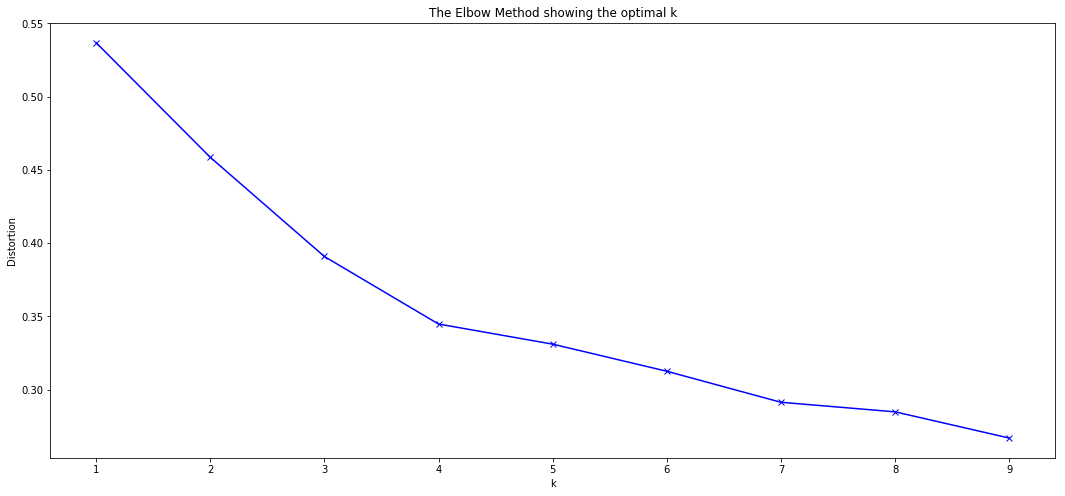

In [74]:
# Plot the elbow
plt.plot()
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Let's run k-means to cluster the neighborhood into 4 clusters, which is the optimal value

In [83]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(mty_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:149]

array([3, 3, 2, 3, 3, 3, 3, 3, 1, 0, 3, 0, 3, 0, 3, 0, 1, 1, 3, 1, 3, 2, 0,
       0, 3, 3, 0, 3, 3, 1, 2, 0, 3, 0, 0, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0,
       0, 3, 1, 2, 0, 0, 0, 3, 0, 0, 0, 3, 3, 0, 3, 3, 0, 3, 0, 0, 1, 3, 0,
       0, 3, 0, 3, 1, 1, 3, 1, 3, 3, 0, 0, 2, 3, 0, 3, 3, 0, 3, 1, 0, 3, 0,
       3, 3, 0, 0, 3, 0, 3, 0, 3, 2, 3, 0, 2, 3, 0, 0, 0, 0, 3, 0, 0, 3, 3,
       1, 3, 0, 0, 2, 0, 0, 1, 0, 3, 0, 0, 3, 0, 3, 3, 2, 2, 2, 0, 0, 3, 0,
       3, 3, 2, 0, 0, 0, 3, 1, 3, 0, 0], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood

In [85]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster', kmeans.labels_)

mty_merged = mty_df

mty_merged = pd.merge(left=mty_df, right=neighborhoods_venues_sorted)

mty_merged.head()

,PostalCode,Neighborhood,State,County,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,64004,Amway,Nuevo Leon,Monterrey,25.7334,-100.3321,0,Candy Store,Motel,Movie Theater,Juice Bar,Afghan Restaurant,Furniture / Home Store,Design Studio,Chocolate Shop,Clothing Store,Cocktail Bar
1,64006,Consulado General de los Estados Unidos de Nor...,Nuevo Leon,Monterrey,25.7334,-100.3321,0,Candy Store,Motel,Movie Theater,Juice Bar,Afghan Restaurant,Furniture / Home Store,Design Studio,Chocolate Shop,Clothing Store,Cocktail Bar
2,64007,Secretaria de Hacienda y CrEdito Publico,Nuevo Leon,Monterrey,25.7334,-100.3321,0,Candy Store,Motel,Movie Theater,Juice Bar,Afghan Restaurant,Furniture / Home Store,Design Studio,Chocolate Shop,Clothing Store,Cocktail Bar
3,64009,Palacio de Gobierno Del Estado de Nuevo Leon,Nuevo Leon,Monterrey,25.7334,-100.3321,0,Candy Store,Motel,Movie Theater,Juice Bar,Afghan Restaurant,Furniture / Home Store,Design Studio,Chocolate Shop,Clothing Store,Cocktail Bar
4,64010,Obrera,Nuevo Leon,Monterrey,25.7334,-100.3321,0,Candy Store,Motel,Movie Theater,Juice Bar,Afghan Restaurant,Furniture / Home Store,Design Studio,Chocolate Shop,Clothing Store,Cocktail Bar


In [86]:
mty_merged.shape

(149, 17)

Finally, let's visualize the resulting clusters

In [87]:
X = mty_merged['Latitude']
Y = mty_merged['Longitude']
Z = np.stack((X, Y), axis=1)

colors = ['red', 'green', 'blue', 'yellow']

for latitude, longitude, county, cluster in zip(mty_merged['Latitude'], mty_merged['Longitude'], mty_merged['County'], mty_merged['Cluster']):
    label = folium.Popup(county + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color=colors[cluster],
        fill_opacity=0.7).add_to(mty_map)  

mty_map

## 5. Examine Clusters

Now, we can examine each cluster and review the venue categories that distinguish each cluster

#### Cluster 0

This Cluster has a wide variety of Venues, including Taco Places and High End Venues, so there will be a lot of competitors and the cost to open a small restaurant might be high

In [42]:
mty_merged.loc[mty_merged['Cluster'] == 0, mty_merged.columns[[1] + list(range(5, mty_merged.shape[1]))]]

,Neighborhood,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Amway,-100.3321,0,Candy Store,Motel,Movie Theater,Juice Bar,Afghan Restaurant,Furniture / Home Store,Design Studio,Chocolate Shop,Clothing Store,Cocktail Bar
1,Consulado General de los Estados Unidos de Nor...,-100.3321,0,Candy Store,Motel,Movie Theater,Juice Bar,Afghan Restaurant,Furniture / Home Store,Design Studio,Chocolate Shop,Clothing Store,Cocktail Bar
2,Secretaria de Hacienda y CrEdito Publico,-100.3321,0,Candy Store,Motel,Movie Theater,Juice Bar,Afghan Restaurant,Furniture / Home Store,Design Studio,Chocolate Shop,Clothing Store,Cocktail Bar
3,Palacio de Gobierno Del Estado de Nuevo Leon,-100.3321,0,Candy Store,Motel,Movie Theater,Juice Bar,Afghan Restaurant,Furniture / Home Store,Design Studio,Chocolate Shop,Clothing Store,Cocktail Bar
4,Obrera,-100.3321,0,Candy Store,Motel,Movie Theater,Juice Bar,Afghan Restaurant,Furniture / Home Store,Design Studio,Chocolate Shop,Clothing Store,Cocktail Bar
5,Condominios Constitucion,-100.3321,0,Candy Store,Motel,Movie Theater,Juice Bar,Afghan Restaurant,Furniture / Home Store,Design Studio,Chocolate Shop,Clothing Store,Cocktail Bar
6,Exseminario,-100.3321,0,Candy Store,Motel,Movie Theater,Juice Bar,Afghan Restaurant,Furniture / Home Store,Design Studio,Chocolate Shop,Clothing Store,Cocktail Bar
8,El Mirador Centro,-100.3321,0,Candy Store,Motel,Movie Theater,Juice Bar,Afghan Restaurant,Furniture / Home Store,Design Studio,Chocolate Shop,Clothing Store,Cocktail Bar
10,Paseo de las Mitras,-100.3727,0,Park,Pharmacy,Auto Workshop,Comedy Club,Department Store,Deli / Bodega,Cycle Studio,Convenience Store,Comfort Food Restaurant,Wings Joint
11,Fidel Velazquez S. N. A. T.,-100.3727,0,Park,Pharmacy,Auto Workshop,Comedy Club,Department Store,Deli / Bodega,Cycle Studio,Convenience Store,Comfort Food Restaurant,Wings Joint


#### Cluster 1

This Cluster includes High End Venues, where might not be ideal to open a Taco Place

In [43]:
mty_merged.loc[mty_merged['Cluster'] == 1, mty_merged.columns[[1] + list(range(5, mty_merged.shape[1]))]]

,Neighborhood,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Obispado,-100.311,1,Café,Arts & Crafts Store,Wings Joint,Diner,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant
12,Loma Linda,-100.311,1,Café,Arts & Crafts Store,Wings Joint,Diner,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant
20,Bortoni,-100.311,1,Café,Arts & Crafts Store,Wings Joint,Diner,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant
23,CROC,-100.311,1,Café,Arts & Crafts Store,Wings Joint,Diner,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant
29,La Amistad,-100.311,1,Café,Arts & Crafts Store,Wings Joint,Diner,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant
31,Francisco Villa,-100.311,1,Café,Arts & Crafts Store,Wings Joint,Diner,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant
45,Lazaro Cardenas,-100.311,1,Café,Arts & Crafts Store,Wings Joint,Diner,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant
60,Sarabia,-100.311,1,Café,Arts & Crafts Store,Wings Joint,Diner,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant
66,Almaguer,-100.311,1,Café,Arts & Crafts Store,Wings Joint,Diner,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant
72,San Jeronimo,-100.311,1,Café,Arts & Crafts Store,Wings Joint,Diner,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant


#### Cluster 2

This Cluster has a no Taco Places, so the Neighborhoods in this Cluster should be considered to open the Restaurant 

In [44]:
mty_merged.loc[mty_merged['Cluster'] == 2, mty_merged.columns[[1] + list(range(5, mty_merged.shape[1]))]]

,Neighborhood,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
32,San angel F-78,-100.3705,2,Pharmacy,Candy Store,Casino,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant
33,Fray Servando Teresa de Mier F-6,-100.3705,2,Pharmacy,Candy Store,Casino,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant
34,18 de Febrero,-100.3705,2,Pharmacy,Candy Store,Casino,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant
35,Tierra y Libertad Sector Heroico,-100.3705,2,Pharmacy,Candy Store,Casino,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant
36,Predio Zapata,-100.3705,2,Pharmacy,Candy Store,Casino,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant
37,Tierra y Libertad Sector Sur,-100.3705,2,Pharmacy,Candy Store,Casino,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant
38,Cnop,-100.3705,2,Pharmacy,Candy Store,Casino,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant
39,Tierra y Libertad Sector Centro,-100.3705,2,Pharmacy,Candy Store,Casino,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant
40,Plan de San Luis,-100.3705,2,Pharmacy,Candy Store,Casino,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant
41,Madero,-100.3705,2,Pharmacy,Candy Store,Casino,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant


#### Cluster 3

This Cluster has a wide variety of Venues, including Taco Places, so there will be a lot of competitors

In [45]:
mty_merged.loc[mty_merged['Cluster'] == 3, mty_merged.columns[[1] + list(range(5, mty_merged.shape[1]))]]

,Neighborhood,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Plutarco Elias Calles,-100.3913,3,Taco Place,Seafood Restaurant,Bus Stop,Convenience Store,Restaurant,Wings Joint,Comfort Food Restaurant,Deli / Bodega,Cycle Studio,Coffee Shop
17,Aztlan,-100.3812,3,Grocery Store,Convenience Store,Electronics Store,Supermarket,Design Studio,Department Store,Deli / Bodega,Cycle Studio,Comfort Food Restaurant,Diner
18,Lomas de La Unidad Modelo,-100.3812,3,Grocery Store,Convenience Store,Electronics Store,Supermarket,Design Studio,Department Store,Deli / Bodega,Cycle Studio,Comfort Food Restaurant,Diner
19,Abelardo Zapata,-100.3812,3,Grocery Store,Convenience Store,Electronics Store,Supermarket,Design Studio,Department Store,Deli / Bodega,Cycle Studio,Comfort Food Restaurant,Diner
21,5 de Mayo,-100.3480,3,Convenience Store,Pool,Burger Joint,Cycle Studio,Taco Place,Fast Food Restaurant,Comedy Club,Deli / Bodega,Comfort Food Restaurant,Wings Joint
24,Valle de San Martin F-24,-100.3761,3,Mexican Restaurant,Wings Joint,Gym,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant
27,Tierra Propia F-35,-100.3761,3,Mexican Restaurant,Wings Joint,Gym,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant
28,5 de Mayo F-93,-100.3495,3,Taco Place,Wings Joint,Diner,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant
30,Villa San angel Topo Chico,-100.3481,3,Taco Place,Wings Joint,Diner,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant
46,Mitras Norte,-100.3971,3,Mexican Restaurant,Convenience Store,Park,Taco Place,Comfort Food Restaurant,Ice Cream Shop,Martial Arts Dojo,Coffee Shop,Pizza Place,Gym


### Based on the results, we recommend that the Entrepreneur consider Neighborhoods in Cluster 2, to open her Taco Place.